# MHD tests

## Imports

In [1]:
# %pip install ../

import os

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,6" # second gpu

# numerics
import jax
import jax.numpy as jnp

# timing
from timeit import default_timer as timer

# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# fluids
from jf1uids import SimulationConfig
from jf1uids import get_helper_data
from jf1uids import SimulationParams
from jf1uids import time_integration
from jf1uids.fluid_equations.fluid import construct_primitive_state2D

from jf1uids import get_registered_variables


## Initiatization

In [2]:
from jf1uids.option_classes.simulation_config import BACKWARDS, FORWARDS, HLL, HLLC, MINMOD, OSHER, PERIODIC_BOUNDARY, BoundarySettings, BoundarySettings1D

print("👷 Setting up simulation...")

# simulation settings
gamma = 5/3

# spatial domain
box_size = 4.0
num_cells = 256

fixed_timestep = False
dt_max = 0.01
num_timesteps = 10

# setup simulation config
config = SimulationConfig(
    runtime_debugging = False,
    progress_bar = True,
    first_order_fallback = False,
    mhd = False,
    self_gravity = True,
    dimensionality = 3,
    box_size = box_size, 
    num_cells = num_cells,
    fixed_timestep = fixed_timestep,
    differentiation_mode = FORWARDS,
    num_timesteps = num_timesteps,
    limiter = MINMOD,
    riemann_solver = HLL,
    # boundary_settings = BoundarySettings(BoundarySettings1D(left_boundary = PERIODIC_BOUNDARY, right_boundary = PERIODIC_BOUNDARY), BoundarySettings1D(left_boundary = PERIODIC_BOUNDARY, right_boundary = PERIODIC_BOUNDARY), BoundarySettings1D(left_boundary = PERIODIC_BOUNDARY, right_boundary = PERIODIC_BOUNDARY))
)

helper_data = get_helper_data(config)

params = SimulationParams(
    t_end = 0.8,
    C_cfl = 0.4,
    dt_max = dt_max,
)

registered_variables = get_registered_variables(config)

👷 Setting up simulation...


In [3]:
from jax.numpy.fft import fftn, ifftn

n_test = 64
x = jnp.linspace(0, 1, n_test)[1:]
# calculate the fourier transform of 1/x
fourier = fftn(-1/x)

print(fourier)

[-297.88074  +0.j         -152.20123 +71.410774j
 -117.14796 +65.83247j     -98.594475+59.83332j
  -86.70315 +54.53175j     -78.33345 +49.906883j
  -72.09975 +45.84237j     -67.276245+42.23307j
  -63.43944 +38.995483j    -60.322952+36.064552j
  -57.749805+33.389328j    -55.59732 +30.929413j
  -53.777527+28.652376j    -52.225677+26.53181j
  -50.89299 +24.545973j    -49.742004+22.676748j
  -48.743534+20.908854j    -47.87451 +19.229319j
  -47.116535+17.62698j     -46.454662+16.092188j
  -45.87685 +14.616491j    -45.37317 +13.192444j
  -44.9355  +11.813414j    -44.557148+10.473462j
  -44.232563 +9.167213j    -43.957237 +7.8897495j
  -43.727432 +6.636552j    -43.540146 +5.4034085j
  -43.393017 +4.186327j    -43.284206 +2.9815638j
  -43.212383 +1.7854922j   -43.176697 +0.5945897j
  -43.176697 -0.59459066j  -43.21239  -1.785491j
  -43.284214 -2.981565j    -43.393024 -4.1863275j
  -43.540146 -5.4034085j   -43.72742  -6.6365604j
  -43.957233 -7.889758j    -44.232563 -9.167221j
  -44.557144-10.4

In [4]:
# from jax.numpy.fft import fftn, ifftn

# def _compute_gravitational_potential(
#     gas_density,
#     grid_spacing: float,
#     dimensionality: int,
#     outflow_boundaries: bool = False,
#     G: float = 1.0,
#     background_density: float = 0.0,
# ):
#     """
#     Compute the gravitational potential via FFT by solving Poisson's equation.
    
#     For periodic boundaries, the method multiplies the density FFT by the Fourier–space
#     Greens function (here using -4πG/k²). For open boundaries (i.e. isolated boundaries),
#     the method of Hockney & Eastwood is used:
    
#       1. The density is embedded in a grid twice as large in every dimension.
#       2. A Green's function is constructed on that extended grid via the minimum–image
#          prescription (making it periodic on the extended domain).
#       3. FFT convolution is performed, and finally the potential is extracted over the
#          original domain.
    
#     Parameters
#     ----------
#     gas_density : array_like
#         The density field on a uniform grid.
#     grid_spacing : float
#         The spacing between grid cells.
#     dimensionality : int
#         The spatial dimension (1, 2, or 3).
#     outflow_boundaries : bool, optional
#         If False (default) the domain is assumed periodic. If True, open (isolated)
#         boundaries are used via the Hockney–Eastwood method.
#     G : float, optional
#         Gravitational constant.
    
#     Returns
#     -------
#     gravitational_potential : array_like
#         The computed gravitational potential on the original grid.
#     """
#     import jax.numpy as jnp
#     from jax.numpy.fft import fftn, ifftn

#     if not outflow_boundaries:
#         # -----------------------------
#         # Periodic boundaries version
#         # -----------------------------
#         # Compute FFT of the density field.
#         density_k = fftn(gas_density)

#         # Build the k–vector (note that fftfreq returns cycles/unit; multiply by 2π).
#         num_cells = gas_density.shape[0]
#         k_base = jnp.fft.fftfreq(num_cells, d=grid_spacing) * 2 * jnp.pi

#         if dimensionality == 1:
#             k = k_base  # 1D case.
#             k_squared = k ** 2
#         elif dimensionality == 2:
#             kx, ky = jnp.meshgrid(k_base, k_base, indexing="ij")
#             k_squared = kx**2 + ky**2
#         elif dimensionality == 3:
#             kx, ky, kz = jnp.meshgrid(k_base, k_base, k_base, indexing="ij")
#             k_squared = kx**2 + ky**2 + kz**2

#         # Avoid division by zero (k = 0 mode).
#         k_squared = jnp.where(k_squared == 0, 1e-12, k_squared)
#         greens_function = jnp.where(k_squared > 1e-12, -4 * jnp.pi * G / k_squared, -1/(4 * jnp.pi))

#         # Multiply in Fourier space and invert.
#         potential_k = greens_function * density_k
#         gravitational_potential = jnp.real(ifftn(potential_k))
#         return gravitational_potential

#     else:
#         # ----------------------------------------------------
#         # Open boundaries version via Hockney & Eastwood method
#         # ----------------------------------------------------
#         #
#         # (a) Extend the domain to twice the size in each dimension.
#         original_shape = gas_density.shape
#         extended_shape = tuple(2 * s for s in original_shape)

#         # Embed the original density in the (0,...,0) corner of the extended grid.
#         extended_density = jnp.zeros(extended_shape, dtype=gas_density.dtype) + background_density
#         slices = tuple(slice(0, s) for s in original_shape)
#         extended_density = extended_density.at[slices].set(gas_density)

#         # (b) Construct the Green's function on the extended grid.
#         #
#         # The Hockney–Eastwood prescription is to compute, for each dimension,
#         #     pos = [0, 1, 2, ..., n-1, 2n - n, ..., 1] * grid_spacing,
#         # which is equivalent to:
#         #
#         #    pos = np.arange(2*n);  pos = where(pos < n, pos, 2*n - pos)
#         #
#         # This yields the “minimum–image” distances from the source placed at the origin.
#         grids = []
#         for s in original_shape:
#             n = s
#             extended_n = 2 * n
#             pos = jnp.arange(extended_n)
#             pos = jnp.where(pos < n, pos, 2 * n - pos)
#             pos = pos * grid_spacing
#             grids.append(pos)

#         # Now create the distance array r on the extended grid.
#         if dimensionality == 1:
#             r = grids[0]  # Already nonnegative.
#         elif dimensionality == 2:
#             x, y = jnp.meshgrid(grids[0], grids[1], indexing="ij")
#             r = jnp.sqrt(x**2 + y**2)
#         elif dimensionality == 3:
#             x, y, z = jnp.meshgrid(grids[0], grids[1], grids[2], indexing="ij")
#             r = jnp.sqrt(x**2 + y**2 + z**2)

#         # Replace any zero distance with grid_spacing (to avoid singularity).
#         r_safe = jnp.where(r == 0, grid_spacing, r)

#         # (c) Define the isolated (open–boundary) Green's function.
#         if dimensionality == 1:
#             # For 1D (solving φ'' = 4πGδ(x)), the solution is φ = -2πG |x|
#             kernel = -2 * jnp.pi * G * r
#         elif dimensionality == 2:
#             # In 2D, φ = -2G log(r)  (up to an additive constant).
#             kernel = -2 * G * jnp.log(r_safe)
#         elif dimensionality == 3:
#             # In 3D, the isolated potential is φ = -G/r.
#             kernel = -G / r_safe

#         # (d) FFT–convolve: Multiply the FFTs of the extended density and the Green's function.
#         density_k_ext = fftn(extended_density)
#         kernel_k_ext = fftn(kernel)
#         potential_ext = jnp.real(ifftn(density_k_ext * kernel_k_ext))

#         # (e) Extract the portion of the potential corresponding to the original grid.
#         gravitational_potential = potential_ext[slices]
#         return gravitational_potential * grid_spacing ** dimensionality


# num_cells = 64

# # Create a 3D grid spanning [0, box_size] in each direction
# x = jnp.linspace(0, box_size, num_cells)[:-1]
# y = jnp.linspace(0, box_size, num_cells)[:-1]

# X, Y = jnp.meshgrid(x, y, indexing="ij")

# # P0 = 1e-2
# # rho0 = 1
# # c_s = jnp.sqrt(gamma * P0 / rho0)

# # # Initialize the density with a sinusoidal perturbation that fits the periodic box.
# # L = jnp.sqrt(jnp.pi * c_s **2 / rho0)
# # rho = 1.0 + 0.01 * jnp.cos(2 * jnp.pi * X / L) * jnp.cos(2 * jnp.pi * Y / L)

# k = 2 * jnp.pi / box_size
# rho = jnp.cos(k * X) * jnp.cos(k * Y)
# rho = rho - jnp.mean(rho)

# gravitational_potential = _compute_gravitational_potential(rho, box_size / (num_cells - 1), 2)

# # plt.plot(x, rho, label="density")
# # plt.plot(x, gravitational_potential, label="potential")
# # plt.plot(x, -4 * jnp.pi / k ** 2 * jnp.cos(k * x), label = "analytical potential")
# # plt.legend()

# # plt.imshow(gravitational_potential)

# plt.imshow(-4 * jnp.pi / (2 * k ** 2) * jnp.cos(k * X) * jnp.cos(k * Y) - gravitational_potential)

# plt.colorbar()

In [5]:
# # -----------------------------
# # Example Test Problem in 2D
# # -----------------------------

# # Set up grid parameters
# N = 128                      # number of cells in each direction for the original domain
# grid_spacing = 1e-3           # grid spacing
# x = jnp.linspace(0, (N-1)*grid_spacing, N)
# y = jnp.linspace(0, (N-1)*grid_spacing, N)
# X, Y = jnp.meshgrid(x, y, indexing="ij")

# # Define a "point-mass" density distribution.
# # We put a single point mass (smeared over one cell) at (x0, y0).
# G_const = 1.0
# M = 1.0                      # mass of the point
# # Choose the point mass to lie well inside the original domain.
# x0 = (N//6) * grid_spacing   
# y0 = (N//6) * grid_spacing   

# # Initialize density to zero and add the point mass.
# density = jnp.ones((N, N)) * 1e-3
# # For simplicity we place the entire mass in one cell.
# density = density.at[N//6, N//6].set(M / (grid_spacing**2))
# # (The division by grid_spacing^2 makes the integrated mass equal to M.)

# # Compute the gravitational potential with outflow (open) boundaries.
# phi_numerical = _compute_gravitational_potential(
#     density,
#     grid_spacing,
#     dimensionality=2,
#     outflow_boundaries=True,
#     G=G_const,
#     background_density=1e-3,
# )

# # Compute the analytic potential away from the singular cell.
# # For a point mass in 2D (with Poisson eqn: ∇^2Φ = 4πGρ) the free-space solution is:
# #   Φ(r) = -2 G M ln(r) + C
# # We choose C such that the potential is zero at r = 1 (for example).

# # Compute the distance from each grid point to the point mass location.
# r = jnp.sqrt((X - x0)**2 + (Y - y0)**2)
# # To avoid the logarithmic singularity, mask out points too close to the source.
# mask = r > (0.5 * grid_spacing)

# # Choose the integration constant such that φ_analytic(1) = -2 G M ln(1) + C = 0.
# C = 0.0  # (any constant works; we compare up to an additive constant)
# phi_analytic = -2 * G_const * M * jnp.log(r) + C

# # For clarity in the comparison, we subtract off the value at a reference radius.
# ref = 10  # reference index away from the source (this is arbitrary)
# ref_val = phi_numerical[ref, ref]
# phi_numerical_adj = phi_numerical - ref_val
# phi_analytic_adj = phi_analytic - phi_analytic[ref, ref]

# # Plot the results (only plotting the region away from the singularity)
# plt.figure(figsize=(12, 5))

# plt.subplot(1,2,1)
# plt.title("Numerical Potential (Open Boundaries)")
# im = plt.imshow(phi_numerical_adj, origin="lower", extent=[x[0], x[-1], y[0], y[-1]])
# plt.colorbar(im)
# plt.plot(x0, y0, "wo", markersize=8, label="Point Mass")
# plt.legend()

# plt.subplot(1,2,2)
# plt.title("Analytic Potential (Point Mass)")
# im = plt.imshow(phi_analytic_adj, origin="lower", extent=[x[0], x[-1], y[0], y[-1]])
# plt.colorbar(im)
# plt.plot(x0, y0, "wo", markersize=8, label="Point Mass")
# plt.legend()

# plt.tight_layout()
# plt.show()

## Setting the initial state

In [6]:
# from jf1uids.fluid_equations.fluid import construct_primitive_state3D

# # Grid size and configuration
# # Define chosen values
# rho0 = 1.0                  # background density
# c_s = 1.0                   # sound speed
# delta = 0.01                # perturbation amplitude (1% perturbation)

# # Use configuration for grid details
# num_cells = config.num_cells
# box_size = config.box_size

# # Create a 3D grid spanning [0, box_size] in each direction
# x = jnp.linspace(0, box_size, num_cells)
# y = jnp.linspace(0, box_size, num_cells)
# z = jnp.linspace(0, box_size, num_cells)
# X, Y, Z = jnp.meshgrid(x, y, z, indexing="ij")

# # Initialize the density with a sinusoidal perturbation that fits the periodic box.
# rho = rho0 * (1.0 + delta *
#               jnp.cos(2 * jnp.pi * X / box_size) *
#               jnp.cos(2 * jnp.pi * Y / box_size) *
#               jnp.cos(2 * jnp.pi * Z / box_size))

# # Initialize velocity fields to zero
# v_x = jnp.zeros_like(rho)
# v_y = jnp.zeros_like(rho)
# v_z = jnp.zeros_like(rho)

# # Initialize pressure assuming an isothermal equation of state: p = c_s^2 * rho
# p = c_s**2 * rho

# # Construct the initial primitive state for the 3D simulation.
# initial_state = construct_primitive_state3D(rho, v_x, v_y, v_z, p, registered_variables)

In [7]:
from jf1uids.fluid_equations.fluid import construct_primitive_state3D

R = 1.0
M = 1.0

rho = jnp.where(helper_data.r < R, M / (2 * jnp.pi * R ** 2 * helper_data.r), 1e-4)

# Initialize velocity fields to zero
v_x = jnp.zeros_like(rho)
v_y = jnp.zeros_like(rho)
v_z = jnp.zeros_like(rho)

# initial thermal energy per unit mass = 0.05
e = 0.05
p = (gamma - 1) * rho * e

# Construct the initial primitive state for the 3D simulation.
initial_state = construct_primitive_state3D(rho, v_x, v_y, v_z, p, registered_variables)

In [8]:
# from matplotlib.colors import LogNorm


# phi_numerical = _compute_gravitational_potential(
#     rho,
#     grid_spacing,
#     dimensionality=3,
#     outflow_boundaries=True,
#     G=G_const,
#     background_density=1e-3,
# )

# # imshow
# plt.imshow(phi_numerical[:, :, 32].T, origin="lower", extent=[0, 1, 0, 1])
# plt.colorbar()

In [9]:
# # plot the potential over r
# plt.plot(helper_data.r.flatten(), phi_numerical.flatten(), label="numerical")

## Simulation

In [10]:
final_state = time_integration(initial_state, config, params, helper_data, registered_variables)

Setting boundary conditions


## Visualization

### Cut

Text(0.5, 1.0, 'Density')

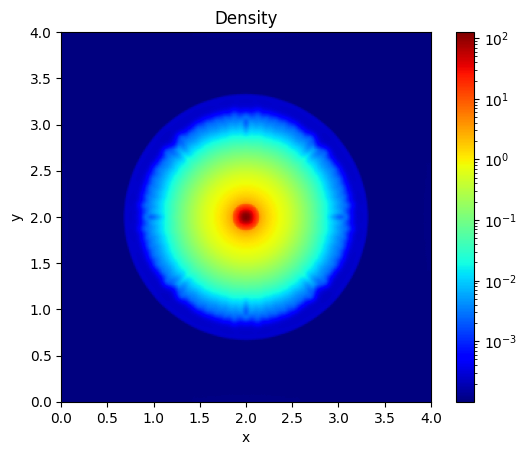

In [11]:
from matplotlib.colors import LogNorm

a = num_cells // 2 - 10
b = num_cells // 2 + 10

plt.imshow(final_state[0, :, :, num_cells // 2].T, cmap = "jet", origin = "lower", extent=[0, box_size, 0, box_size], norm = LogNorm())
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")

plt.title("Density")

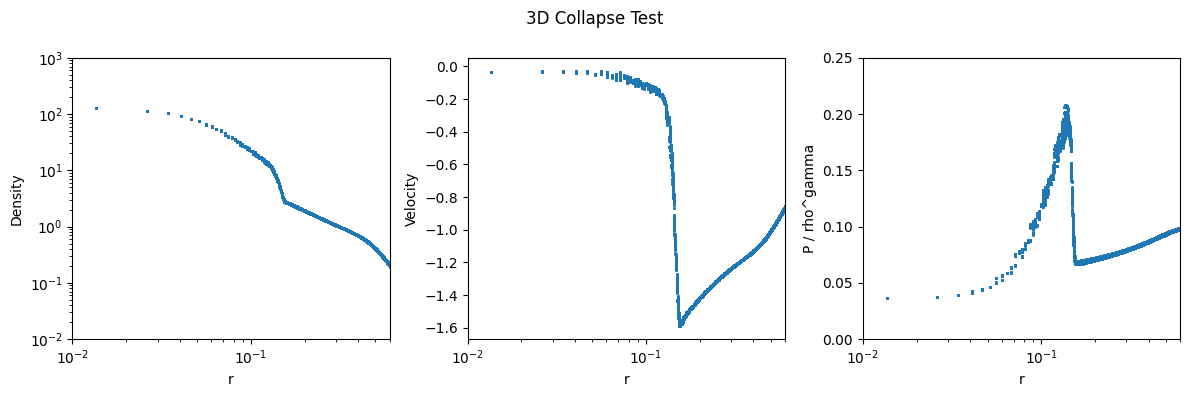

In [12]:
# plot the radial density profile rho over r in a log-log plot

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.scatter(helper_data.r.flatten(), final_state[registered_variables.density_index].flatten(), label="Final Density", s = 1)
# x and y log scale
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlim(1e-2, 6e-1)
ax1.set_ylim(1e-2, 1e3)
ax1.set_xlabel("r")
ax1.set_ylabel("Density")

# velocity profile
v_r = -jnp.sqrt(final_state[registered_variables.velocity_index.x] ** 2 + final_state[registered_variables.velocity_index.y] ** 2 + final_state[registered_variables.velocity_index.z] ** 2)

ax2.scatter(helper_data.r.flatten(), v_r.flatten(), label="Radial Velocity", s = 1)
# log x scale
ax2.set_xscale("log")
ax2.set_xlim(1e-2, 6e-1)
ax2.set_xlabel("r")
ax2.set_ylabel("Velocity")

# plot P / rho^gamma

ax3.scatter(helper_data.r.flatten(), final_state[registered_variables.pressure_index].flatten() / final_state[registered_variables.density_index].flatten() ** gamma, label="P / rho^gamma", s = 1)
ax3.set_xlim(box_size / num_cells, 6e-1)
ax3.set_xlabel("r")
ax3.set_ylabel("P / rho^gamma")
ax3.set_xscale("log")
ax3.set_ylim(0, 0.25)
ax3.set_xlim(1e-2, 6e-1)

fig.suptitle("3D Collapse Test")

plt.tight_layout()